# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 18 апреля 2018, 06:00 <br\>
**Штраф за опоздание:** -3 балла после 06:00 18 апреля, -6 баллов после 06:00 25 апреля, -9 баллов после 06:00 2 мая

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline
%load_ext pycodestyle_magic

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"сивков".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print("Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)
     )

Имплементируйте обучение логистической регрессии с L1 регуляризацией с помощью метода  Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

$$ \frac{\partial L}{\partial w_i} = \dots $$

## Имплементация (5 баллов)

In [54]:
# %%pycodestyle
from sklearn.base import BaseEstimator, ClassifierMixin
from IPython.display import display, Math


class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """

    def __init__(self, C=0.5, alpha=0.01, max_epoch=5, batch_size=32):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        batch_size - максимальный размер мини батча
        """

        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_size = batch_size
        self.model = None

    def fit(self, X, y, display_=(), count_losses=False):
        '''
        Обучение модели
        '''
        self.model = np.random.uniform(
            low=0.0,
            high=0.1,
            size=(X.shape[1] + 1)
        )
        return self.partial_fit(X, y, display_, count_losses)

    def partial_fit(self, X, y, display_=(), count_losses=False):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
        curr_epoch = 0

        global_iter = 0

        losses = []

        while curr_epoch < self.max_epoch:
            indicies = np.arange(X.shape[0])
            np.random.shuffle(indicies)

            iterator = 0
            while indicies.size > 0:
                batch_indicies = np.random.choice(
                    indicies,
                    size=np.min((self.batch_size, indicies.size)),
                    replace=True
                )
                indicies = np.setdiff1d(indicies, batch_indicies)
                grad = self.__gradient(
                    X[batch_indicies],
                    y[batch_indicies],
                    global_iter
                )
                self.model -= self.alpha / (curr_epoch + 1) * grad

                if 'gradient' in display_:
                    self.__print_grad(grad, curr_epoch, iterator)
                iterator += 1
                global_iter += 1

                if count_losses:
                    losses.append(self.__loss(X, y))

            if 'loss' in display_:
                self.__print_loss(self.__loss(X, y), curr_epoch)

            curr_epoch += 1

        if count_losses:
            return self, losses
        else:
            return self

    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        predict_data = (X * self.model[1:]).sum(axis=1) + self.model[0]
        y_hat = np.zeros((X.shape[0],), dtype=np.float64)
        y_hat[predict_data > 0] = 1.0
        y_hat[predict_data < 0] = 0.0
        return y_hat

    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        predict_data = (X * self.model[1:]).sum(axis=1) + self.model[0]
        predict_data[predict_data > 0] /= predict_data.max() / 6
        predict_data[predict_data < 0] /= np.abs(predict_data.min()) / 6
        sigm = 1 / (1 + np.exp(-1 * predict_data))
        y_hat_proba = np.empty((X.shape[0], 2), dtype=np.float64)

        y_hat_proba[:, 1] = sigm
        y_hat_proba[:, 0] = 1 - sigm
        return y_hat_proba

    def __loss(self, X, y):
        tmp_y = y * 2 - 1
        margin = tmp_y * ((X * self.model[1:]).sum(axis=1) + self.model[0])
        margin[margin > 0] /= margin.max() / 6
        margin[margin < 0] /= np.abs(margin.min()) / 6
        res = (np.log(1 + np.exp((-1) * margin)).sum() / X.shape[0] +
               np.abs(self.model).sum() * self.C / X.shape[0]
               )
        return res

    def __gradient(self, X, y, global_iter):
        tmp_y = y * 2 - 1
        margin = tmp_y * ((X * self.model[1:]).sum(axis=1) + self.model[0])
        margin[margin > 0] /= margin.max() / 6
        margin[margin < 0] /= np.abs(margin.min()) / 6
        mul = (tmp_y * (-1 / (1 + np.exp(margin)))).reshape(-1, 1) * X
        res = np.empty((X.shape[1] + 1,), dtype=np.float64)
        res[1:] = (mul.sum(axis=0) / X.shape[0] +
                   np.sign(self.model[1:] ** global_iter) * self.C / X.shape[0]
                   )
        res[0] = (tmp_y * (-1 / (1 + np.exp(margin)))).sum()
        return res

    @staticmethod
    def __print_grad(grad, epoch, iteration):
        tex = r'epoch \ %i \ batch \ %i :' % (epoch + 1, iteration + 1)
        # for i in range(grad.size):
        #     tex +=\
        #        r'\frac{\partial L}{\partial w_{%d}} = %f \ \ \ ' % (i, grad[i])
        display(Math(tex))

    @staticmethod
    def __print_loss(loss, epoch):
        display(Math(r'epoch \ %i \ loss: \ L = %f' % (epoch + 1, loss)))

## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

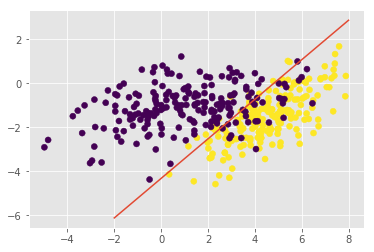

In [55]:
np.random.seed(0)
C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

my_clf = MySGDClassifier(max_epoch=10)
my_clf.fit(X, y, display_=['loss', 'gradient'])

plt.scatter(X[:, 0], X[:, 1], c=y)
x = np.arange(-2, 9)
y = -1 * (x * my_clf.model[1] + my_clf.model[0]) / my_clf.model[2]
plt.plot(x, y)

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [3]:
from sklearn.datasets import make_classification

In [4]:
X, y = make_classification(n_samples=100000, n_features=10,
                           n_informative=4, n_redundant=0,
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

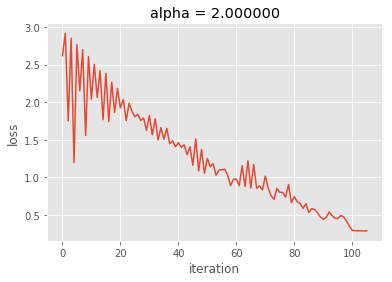

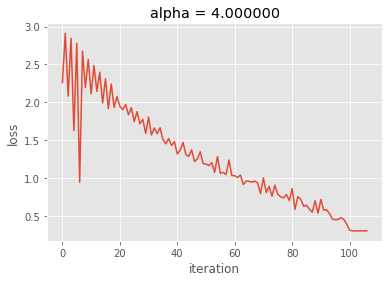

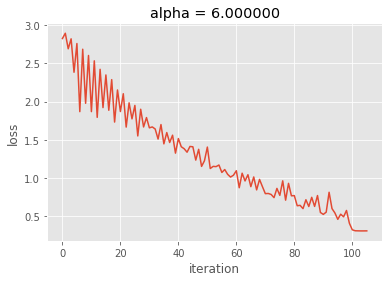

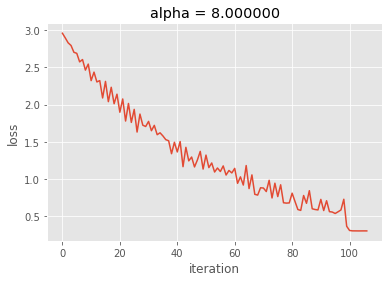

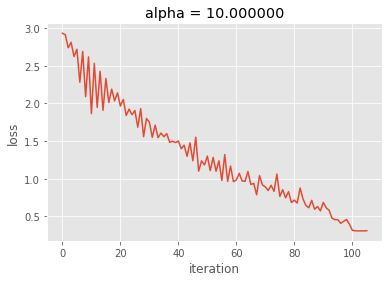

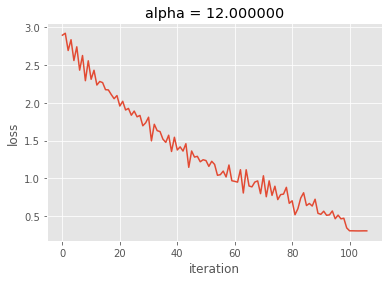

In [8]:
# вручную подбирал параметры, при большем числе итераций loss стабильный
for i in range(6):
    alpha = 2 * (i + 1)
    my_clf = MySGDClassifier(alpha=alpha, max_epoch=1, batch_size=1024)
    loss = my_clf.fit(X, y, count_losses=True)
    plt.figure(i + 1)
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.title('alpha = %f' % alpha)

    plt.plot(np.arange(len(loss[1])), loss[1])

## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

In [5]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

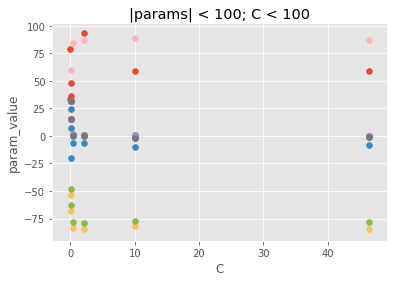

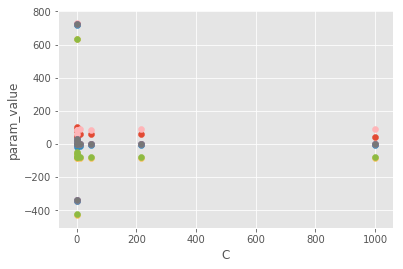

In [12]:
C = np.logspace(3, -3, 10)
params = np.empty((C.size, X.shape[1] + 1), dtype=np.float32)
for i in range(C.size):
    my_clf = MySGDClassifier(C=(1 / C[i]), alpha=2, max_epoch=1, batch_size=1024)
    my_clf.fit(X, y)
    params[i, :] = my_clf.model

for i in range(params.shape[1]):
    plt.xlabel('C')
    plt.ylabel('param_value')
    mask = np.logical_and(np.abs(params[:, i]) < 100, C < 100)
    plt.title('|params| < 100; C < 100')
    plt.scatter(C[mask], params[mask, i])

plt.figure()
for i in range(params.shape[1]):
    plt.xlabel('C')
    plt.ylabel('param_value')
    plt.scatter(C, params[:, i])
# цвет обозначает номер коэффициента


# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [11]:
import pandas as pd
import numpy as np

In [12]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#    filepath = './trainingData_tabular_chunk%d.csv' % chunk
#    df_list.append(pd.read_csv(filepath, sep=','))
# df_data = pd.concat(df_list)

# Загрузка одной части данных
filepath = './trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

In [13]:
df_data.shape

(500000, 45)

In [14]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [15]:
df_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [16]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.504702

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [17]:
print(df_data['opponent_hero_card_id'].nunique(),
      ' - opponent numb of uniq hero cards')
print(df_data['player_hero_card_id'].nunique(),
      ' - player numb of uniq hero cards')

9  - opponent numb of uniq hero cards
9  - player numb of uniq hero cards


In [18]:
def encode_df(df_data):
    for col in df_data.columns:
        uniq_c = df_data[col].nunique()
        if uniq_c < 10 and uniq_c > 2:
            tmp = pd.get_dummies(df_data.loc[:, col],
                                 prefix=col,
                                 prefix_sep='='
                                 )
            tmp = tmp.loc[:, tmp.columns[1:]]
            df_data = pd.concat([df_data, tmp], axis=1)
    return df_data


df_data = encode_df(df_data)

In [19]:
df_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

In [22]:
cols = df_data.columns
y = np.float32(df_data.loc[:, cols[1]].as_matrix())
X = np.float32(df_data.loc[:, cols[2:]].as_matrix())

In [23]:
model = Pipeline(
    [
     ('sscaler', StandardScaler()),
     ('model', MySGDClassifier(alpha=2, max_epoch=2, batch_size=2048))
     ]
      )
model.fit(X, y)
# warning из-за переполнения при рассчёте регуляризации
# при возведении векторов параметров в степень

/home/asivkov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:125: RuntimeWarning: overflow encountered in power


Pipeline(memory=None,
     steps=[('sscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', MySGDClassifier(C=0.5, alpha=2, batch_size=2048, max_epoch=2))])

## Применение модели (2 балла)

#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [24]:
filepath = './testData_tabular_chunk5.csv'
test_data = pd.read_csv(filepath, sep=',')
test_data.columns = test_data.columns.str.replace('.', '_')

# взял часть чтобы в память влезало, mean 0.505 на этой части
test_data = test_data.loc[:test_data.shape[0] // 5, :]
X_test = encode_df(test_data)
X_test = np.float32(X_test.loc[:, X_test.columns[2:]].as_matrix())
# pd.read_csv считает первую строку названием поля,
# поэтому я отредактировал данные, написал в первой строке
# txt файла слово decision
y_test = np.float32(
    pd.read_csv('./deprecated_testLabels.txt', sep='\n').as_matrix()
)
y_test = y_test[:X_test.shape[0]]

In [25]:
pred = model.predict_proba(X_test)
roc_auc_score(y_test, pred[:, 1])

0.5149639800738863